# Gen-LM-with-LSTM
## Generative Language Model with LSTM for Arabic Poetry

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import time

<a name='1'></a>
## 1 - Data Preprocessing

In [2]:
# download a file form github
# "https://github.com/omarMokh/ArabicPoetryCollection/blob/main/poems_part_1.txt"
# "https://github.com/omarMokh/ArabicPoetryCollection/blob/main/poems_part_2.txt"
# "https://github.com/omarMokh/ArabicPoetryCollection/blob/main/poems_part_3.txt"

def down_file(file_name):
    # Raw file URL
    file_url = f"https://raw.githubusercontent.com/omarMokh/ArabicPoetryCollection/main/{file_name}"
    !wget {file_url}

down_file("poems_part_1.txt")
down_file("poems_part_2.txt")
down_file("poems_part_3.txt")

--2025-02-22 18:17:47--  https://raw.githubusercontent.com/omarMokh/ArabicPoetryCollection/main/poems_part_1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12005242 (11M) [text/plain]
Saving to: ‘poems_part_1.txt’

poems_part_1.txt    100%[===================>]  11.45M  --.-KB/s    in 0.1s    

2025-02-22 18:17:48 (93.6 MB/s) - ‘poems_part_1.txt’ saved [12005242/12005242]

--2025-02-22 18:17:48--  https://raw.githubusercontent.com/omarMokh/ArabicPoetryCollection/main/poems_part_2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [3]:
file1 = "poems_part_1.txt"
file2 = "poems_part_2.txt"
file3 = "poems_part_3.txt"

lines = []

def extract_lines(file, lines):
  with open(file) as f:
      for line in f:
          line = line.strip()
          if line:
              lines.append(line)

extract_lines(file1, lines)
extract_lines(file2, lines)
extract_lines(file3, lines)

n_lines = len(lines)
print(f"Number of lines: {n_lines}")

Number of lines: 300000


In [4]:
preprocessed_lines = []
allowed_chars = ['\n', ' ', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ـ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', 'ﻻ']

for line in lines:
    line = [c for c in line if c in allowed_chars]
    preprocessed_lines.append(''.join(line))

In [5]:
text = '\n'.join(preprocessed_lines)

vocab = sorted(set(text))
vocab.insert(0, '[UNK]')     # Add a special character for any unknown
vocab.insert(1, '')          # Add the empty character for padding.

print(f'{len(vocab)} unique characters')
print(vocab)

42 unique characters
['[UNK]', '', '\n', ' ', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ـ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', 'ﻻ']


In [6]:
def line_to_tensor(line, vocab):
    chars = tf.strings.unicode_split(input=line, input_encoding='UTF-8')
    ids = layers.StringLookup(vocabulary=vocab, mask_token=None)(chars)
    return ids

In [7]:
def text_from_ids(ids, vocab):
    chars = layers.StringLookup(vocabulary=vocab, mask_token=None, invert=True)(ids)
    text = tf.strings.reduce_join(chars, axis=-1)
    return text.numpy().decode('UTF-8')

In [8]:
train_lines = preprocessed_lines[0:-5000]
eval_lines = preprocessed_lines[-5000:]

In [9]:
print(f"Total number of lines: {len(preprocessed_lines)}")
print(f"Number of training lines: {len(train_lines)}")
print(f"Number of evaluation lines: {len(eval_lines)}")

Total number of lines: 300000
Number of training lines: 295000
Number of evaluation lines: 5000


In [10]:
def split_input_target(sequence):

    # Create the input sequence by excluding the last character
    input_text = sequence[:-1]
    # Create the target sequence by excluding the first character
    output_text = sequence[1:]

    return input_text, output_text

In [11]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [12]:
def create_batch_dataset(lines, vocab, seq_length=100, batch_size=64):

    single_line = '\n'.join(lines)

    all_ids = line_to_tensor(line=single_line, vocab=vocab)

    ds_ids = tf.data.Dataset.from_tensor_slices(all_ids)

    ds_ids = ds_ids.batch(batch_size=seq_length+1, drop_remainder=True)

    ds_xy = ds_ids.map(split_input_target)

    ds = ds_xy.batch(batch_size=batch_size, drop_remainder=True)\
              .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [13]:
ds_train = create_batch_dataset(lines=train_lines, vocab=vocab, seq_length=100, batch_size=64)
ds_eval = create_batch_dataset(lines=eval_lines, vocab=vocab, seq_length=100, batch_size=64)

In [14]:
for x_batch, y_batch in ds_train.take(1):
    x_1 = x_batch[0]
    y_1 = y_batch[0]
    print(f"x_1: {x_1}")
    print(f"y_1: {y_1}", "\n")
    print(f"x_1: {text_from_ids(x_1, vocab)}")
    print(f"y_1: {text_from_ids(y_1, vocab)}")

x_1: [ 6 34 10  3 35 36  3 35 11 34 29  3 10 34  6 16 34 10 31  3 28 36 40  3
  3 31 32 18  3 13 37 18 39  3 10 34 36 24 40 16 12  3 34 34 36 24 40 16
  2 31  6 36 33 35  3 38 35 10  3 13 21 15 38 36  3 36 16 38 40  3  3 35
 36  3 10 34 32 38 34  3 10 34 35 20 29 39  3 38 10 34 24 20 40 16  2 22
 40 36 18 35]
y_1: [34 10  3 35 36  3 35 11 34 29  3 10 34  6 16 34 10 31  3 28 36 40  3  3
 31 32 18  3 13 37 18 39  3 10 34 36 24 40 16 12  3 34 34 36 24 40 16  2
 31  6 36 33 35  3 38 35 10  3 13 21 15 38 36  3 36 16 38 40  3  3 35 36
  3 10 34 32 38 34  3 10 34 35 20 29 39  3 38 10 34 24 20 40 16  2 22 40
 36 18 35  3] 

x_1: ألا من مبلغ الأحلاف عني  فقد تهدى النصيحة للنصيح
فأنكم وما تزجون نحوي  من القول المرغى والصريح
سيندم
y_1: لا من مبلغ الأحلاف عني  فقد تهدى النصيحة للنصيح
فأنكم وما تزجون نحوي  من القول المرغى والصريح
سيندم 


<a name='2'></a>
## 2 - Building The Language Model

In [15]:
input = layers.Input(shape=(None,))

x = layers.Embedding(input_dim=len(vocab), output_dim=256)(input)

lstm_output = layers.LSTM(
    units=512, activation='tanh', dropout=0.5, recurrent_dropout=0.5, return_sequences=True
)(x) # return_state=True

output = layers.Dense(units=len(vocab), activation=tf.nn.log_softmax)(lstm_output)

model = tf.keras.Model(inputs=input, outputs=output)

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 256)           │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 512)           │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 42)            │          21,546 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,607,210 (6.13 MB)

 Trainable params: 1,607,210 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00125),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

# from_logits=True: This parameter informs the loss function that the output values
# generated by the model are not normalized like a probability distribution.
# This is our case, since our GRULM model uses a log_softmax activation rather than the softmax

In [18]:
# check_point_cb = tf.keras.callbacks.ModelCheckpoint(
#     filepath='model_weights/epoch_{epoch}.weights.h5',
#     monitor='loss',
#     save_weights_only=True)

# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='loss',
#     patience=3,
#     min_delta=0.01,
#     factor=0.1,
#     min_lr=1e-6,
#     verbose=1
# )

<a name='3'></a>
## 3 - Training The Language Model

In [19]:
# Dataset without diacritical marks
# tf.config.run_functions_eagerly(True)
history = model.fit(ds_train, epochs=30, verbose=2)

Epoch 1/30
2260/2260 - 234s - 104ms/step - loss: 2.2104
Epoch 2/30
2260/2260 - 230s - 102ms/step - loss: 2.0340
Epoch 3/30
2260/2260 - 229s - 101ms/step - loss: 2.0012
Epoch 4/30
2260/2260 - 229s - 101ms/step - loss: 1.9856
Epoch 5/30
2260/2260 - 229s - 101ms/step - loss: 1.9759
Epoch 6/30
2260/2260 - 228s - 101ms/step - loss: 1.9689
Epoch 7/30
2260/2260 - 228s - 101ms/step - loss: 1.9634
Epoch 8/30
2260/2260 - 229s - 101ms/step - loss: 1.9587
Epoch 9/30
2260/2260 - 228s - 101ms/step - loss: 1.9545
Epoch 10/30
2260/2260 - 228s - 101ms/step - loss: 1.9509
Epoch 11/30
2260/2260 - 229s - 101ms/step - loss: 1.9477
Epoch 12/30
2260/2260 - 228s - 101ms/step - loss: 1.9448
Epoch 13/30
2260/2260 - 228s - 101ms/step - loss: 1.9423
Epoch 14/30
2260/2260 - 229s - 101ms/step - loss: 1.9395
Epoch 15/30
2260/2260 - 228s - 101ms/step - loss: 1.9373
Epoch 16/30
2260/2260 - 228s - 101ms/step - loss: 1.9351
Epoch 17/30
2260/2260 - 228s - 101ms/step - loss: 1.9333
Epoch 18/30
2260/2260 - 228s - 101ms/ste

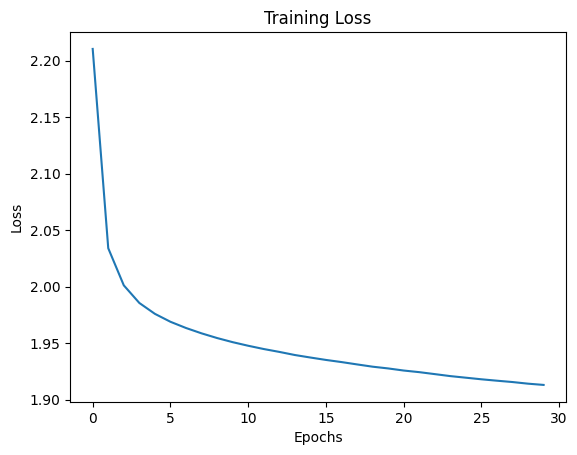

In [20]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [21]:
model.save_weights('model.weights.h5')

In [22]:
# Redefine the model with 3 inputs and 3 outputs
input_seq  = layers.Input(shape=(None,))

initial_forward_h = layers.Input(shape=(512,))
initial_forward_c = layers.Input(shape=(512,))

x = layers.Embedding(input_dim=len(vocab), output_dim=256)(input_seq)

lstm_output, forward_h, forward_c = layers.LSTM(
    units=512, activation='tanh', return_sequences=True, return_state=True
)(x, initial_state=[initial_forward_h, initial_forward_c])

output = layers.Dense(units=len(vocab), activation=tf.nn.log_softmax)(lstm_output)

inference_model = tf.keras.Model(
    inputs=[input_seq, initial_forward_h, initial_forward_c],
    outputs=[output, forward_h, forward_c]
)

In [48]:
inference_model.load_weights("model.weights.h5")

In [49]:
inference_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │         10,752 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 512),    │      1,574,912 │ embedding_1[0][0],     │
│                           │ (None, 512), (None,    │                │ input_layer_2[0][0],   │
│                           │ 512)]                  │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 42)       │         21,546 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,607,210 (6.13 MB)

 Trainable params: 1,607,210 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

<a name='4'></a>
## 4 - Evaluating The Language Model

In [50]:
def log_perplexity(preds, target):
    PADDING_ID = 1

    # Calculate log probabilities for predictions using one-hot encoding
    log_p = np.sum(preds * tf.one_hot(target, depth=preds.shape[-1]), axis= -1)
    # Identify non-padding elements in the target
    non_pad = 1.0 - np.equal(target, PADDING_ID)
    # Apply non-padding mask to log probabilities to exclude padding
    log_p = log_p * non_pad                             # Get rid of the padding
    # Calculate the log perplexity by taking the sum of log probabilities and dividing by the sum of non-padding elements
    log_ppx = np.sum(log_p, axis=-1) / np.sum(non_pad, axis=-1)
    # Compute the mean of log perplexity
    log_ppx = np.mean(log_ppx)

    return -log_ppx

In [51]:
x = []
y = []

for x_batch, y_batch in ds_eval:
    x.append(x_batch)
    y.append(y_batch)

x = tf.concat(x, axis=0)
y = tf.concat(y, axis=0)

In [53]:
# tf.config.run_functions_eagerly(True)

initial_state = tf.zeros((x.shape[0], 512))

predicted_logits, _, _ = inference_model.predict(
    [x, initial_state, initial_state], verbose=1
)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [54]:
# Dataset of 200K lines and without diacritical marks and LSTM architecture
log_ppx = log_perplexity(predicted_logits, y)
print(f'The log perplexity and perplexity of the model are {log_ppx:.3f} and {np.exp(log_ppx):.3f} respectively')

The log perplexity and perplexity of the model are 1.865 and 6.454 respectively


<a name='5'></a>
## 5 - Generating Language with the trained Model

In [55]:
def temperature_random_sampling(log_probs, temperature=1.0):
    """Temperature Random sampling from a categorical distribution. The higher the temperature, the more
       random the output. If temperature is close to 0, it means that the model will just return the index
       of the character with the highest input log_score

    Args:
        log_probs (tf.Tensor): The log scores for each characeter in the dictionary
        temperature (number): A value to weight the random noise.
    Returns:
        int: The index of the selected character
    """
   # Generate uniform random numbers with a slight offset to avoid log(0)
    u = tf.random.uniform(minval=1e-6, maxval=1.0 - 1e-6, shape=log_probs.shape)

    # Apply the Gumbel distribution transformation for randomness
    g = -tf.math.log(-tf.math.log(u))

    # Adjust the logits with the temperature and choose the character with the highest score
    return tf.math.argmax(log_probs + g * temperature, axis=-1)

In [56]:
tf.config.run_functions_eagerly(True)

class GenerativeModel(tf.keras.Model):
    def __init__(self, model, vocab, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.vocab = vocab

    @tf.function
    def generate_one_step(self, inputs, states):

        input_ids = line_to_tensor(inputs, self.vocab)
        input_ids = input_ids.to_tensor()

        predicted_logits, forward_h, forward_c = self.model(
            [input_ids, *states], training=False
        ) # output, forward_h, forward_c

        # Get only last element of the sequence (last char)
        predicted_logits = predicted_logits[0, -1, :]

        predicted_ids = temperature_random_sampling(predicted_logits, self.temperature)

        predicted_chars = text_from_ids([predicted_ids], self.vocab)

        new_states = (forward_h, forward_c)

        return tf.expand_dims(predicted_chars, 0), new_states

    def generate_n_chars(self, num_chars, prefix):
        states = (
            tf.zeros((1, 512)),  # Forward hidden state
            tf.zeros((1, 512)),  # Forward cell state
        )

        next_char = tf.constant([prefix])
        result = [next_char]
        for _ in range(num_chars):
            next_char, states = self.generate_one_step(next_char, states)
            result.append(next_char)

        return tf.strings.join(result)[0].numpy().decode('utf-8')

In [46]:
start = "الحياة"
n_chars = 300

tf.random.set_seed(101)

tic = time.time()

gen = GenerativeModel(inference_model, vocab, temperature=0.2)
poem = gen.generate_n_chars(n_chars, start)

toc = time.time()

print(poem)
print(f"\n\nRun time on GPU: {toc-tic:.1f}s")

الحياة بها  والموت ينفع من أعين المجد من عقل
والله ما أنت المطي والأعداء  والأرض من عيني وأنت المقام
ولم يعرف الناس إلا من الليالي  ولا أرى الموت المعاطف من العلى
ولا تستطيع الناس من قبل العلى  ولا تركت الأعداء من مستهجره
أبى الدهر في الأيام من مستجيره  ولا عجب إن المنايا والمنايا  ولا أرى من معاليه المطا


Run time on GPU: 6.9s


In [63]:
start = "غادر حبيبى"
n_chars = 1000

tf.random.set_seed(1000)

tic = time.time()

gen = GenerativeModel(inference_model, vocab, temperature=0.2)
poem = gen.generate_n_chars(n_chars, start)

toc = time.time()

print(poem)
print(f"\n\nRun time on GPU: {toc-tic:.1f}s")

غادر حبيبى  وأنت يا من يدي الأرض من أحد
ولا تستطيع الأنس في الأحباب من  قد أتى الناس من أعلى المنايا والمنايا
وأنت الذي أنت من الأمر من  أعدائه في الحال والإحسان
والحمد من أن يرى الأيام من حبه  في الناس من أن يرى الملك المنازل
ولا تعجبن بالمدح من أحمد  ولا ترى الأيام من أحمد العلم
والله من أن يروح الملك من أرض  ولا ترى عن من العلم من أحمد المنقد
وأنت الذي أحمد الأحباب من أحبابه  في الحال من أحبابه والمنايا
ولا تستطيع الله من مدح العلى  ولا ترى من مدحه من محاسنه
وأنت الذي أنت الملوك من العلى  في العلم في الأمر والأنفاس والسمر
ولا ترى الأحباب من أن يقول به  ولا تركت به الأيام من أحبابه
ولا تنكر الأعداء من أمر المنى  والمال في الأيام من أحبابه
وأنت الذي يرجى المدام على  أرض المدام به والمعاليه
والمال يا من يدي الملك من  يوم الحسن في الأحباب من أحمد
والله من أن يرى المدح من كل ما  يحمي الملاحة من أن يتوجد
والله من أن يرى الأمر المنى  والمحب في الأرض والأعداء والحسن
ولا تحسب الأيام من حسن العلى  في الملك لا تعد المعالي والمال
وما الناس في الأيام والأمر من  أن يرى الأعداء من أن يتعب
ولا تنسى